# Walmart 구매 데이터 분석 보고서 (가설 검정 포함)

본 보고서는 Walmart 구매 데이터를 활용해 고객 특성과 환경 요인에 따른 구매금액(Purchase)의 차이를 확인하고, 가설 기반으로 통계 검정을 수행하여 시사점을 도출한다.

분석 범위
- 변수: 사용자 특성(Gender, Age, Marital_Status, Occupation), 도시 유형(City_Category, Stay_In_Current_City_Years), 제품 카테고리(Product_Category), 구매금액(Purchase)
- 주의: City_Category, Occupation, Product_Category는 마스킹된 값이므로, 실제 의미(도시 규모/직업명/카테고리명)를 단정하지 않고 유형 간 차이 여부 중심으로 해석한다.

## 0. 환경 설정

한글이 그래프에서 깨지는 문제부터 먼저 잡는다.  
그리고 이후 셀들이 좀 깔끔하게 보이도록 기본 설정을 해둔다.

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# 한글 폰트 설정 (환경마다 다르니 가능한 폰트 후보를 순서대로 시도)
from matplotlib import font_manager, rcParams

def set_korean_font():
    candidates = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "Noto Sans KR"]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for c in candidates:
        if c in available:
            rcParams["font.family"] = c
            break
    rcParams["axes.unicode_minus"] = False

set_korean_font()

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)
import os
from matplotlib import font_manager, rcParams

font_path = r"C:\Windows\Fonts\malgun.ttf"

if os.path.exists(font_path):
    font_manager.fontManager.addfont(font_path)
    font_name = font_manager.FontProperties(fname=font_path).get_name()
    rcParams["font.family"] = font_name
    rcParams["axes.unicode_minus"] = False
    print("설정된 폰트:", font_name)
else:
    print("폰트 파일을 찾지 못함:", font_path)


설정된 폰트: Malgun Gothic


## 1. 데이터 불러오기

데이터를 불러온 뒤, 주요 컬럼이 기대한 스키마와 일치하는지 확인한다.
(파일명이 다를 경우 아래 경로만 수정한다.)

In [16]:
# 파일 경로
df = pd.read_csv("./data/walmart.csv")

df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


## 2. 데이터 점검

분석에 앞서 다음을 확인한다.
- 결측치 존재 여부
- 컬럼 타입 및 범주형/연속형 구분 필요성
- Purchase의 분포 및 스케일(평균, 중앙값 등)

해당 점검 결과는 전처리 방향과 가설 검정의 적절한 방법 선택에 영향을 준다.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [18]:
# 결측치
df.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

In [19]:
# 기본 요약
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
User_ID,550068.0,NaN,NaN,NaN,1003028.842401,1727.591586,1000001.0,1001516.0,1003077.0,1004478.0,1006040.0
Product_ID,550068,3631,P00265242,1880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,550068,2,M,414259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,550068,7,26-35,219587,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,550068.0,NaN,NaN,NaN,8.076707,6.52266,0.0,2.0,7.0,14.0,20.0
City_Category,550068,3,B,231173,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stay_In_Current_City_Years,550068,5,1,193821,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,550068.0,NaN,NaN,NaN,0.409653,0.49177,0.0,0.0,0.0,1.0,1.0
Product_Category,550068.0,NaN,NaN,NaN,5.40427,3.936211,1.0,1.0,5.0,8.0,20.0
Purchase,550068.0,NaN,NaN,NaN,9263.968713,5023.065394,12.0,5823.0,8047.0,12054.0,23961.0


## 3. 전처리 (분석에 필요한 최소한)

핵심은 2가지다.

1) 숫자인 척하는 범주형을 category로 바꾸기  
2) 순서가 있는 범주(Age, Stay_In_Current_City_Years)는 ordered category로 바꾸기

In [20]:
# 컬럼명 공백 방지
df.columns = df.columns.str.strip()

# 숫자인 척하는 범주형
for col in ["Occupation", "Product_Category", "Marital_Status"]:
    if col in df.columns:
        df[col] = df[col].astype("category")

# Age는 순서형 범주
age_order = ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']
if "Age" in df.columns:
    df["Age"] = pd.Categorical(df["Age"], categories=age_order, ordered=True)

# Stay_In_Current_City_Years도 순서형 범주
stay_order = ['0', '1', '2', '3', '4+']
if "Stay_In_Current_City_Years" in df.columns:
    df["Stay_In_Current_City_Years"] = pd.Categorical(
        df["Stay_In_Current_City_Years"], categories=stay_order, ordered=True
    )

df.dtypes

User_ID                          int64
Product_ID                      object
Gender                          object
Age                           category
Occupation                    category
City_Category                   object
Stay_In_Current_City_Years    category
Marital_Status                category
Product_Category              category
Purchase                         int64
dtype: object

## 4. 빠른 개요 (Executive Summary용 숫자)

보고서 앞부분에 넣을 만한 숫자만 뽑는다.

In [21]:
summary = pd.DataFrame({
    "총 거래 수": [len(df)],
    "총 고객 수": [df["User_ID"].nunique()],
    "총 상품 수": [df["Product_ID"].nunique()],
    "총 매출(합계 Purchase)": [df["Purchase"].sum()],
    "평균 구매금액": [df["Purchase"].mean()],
    "중앙값 구매금액": [df["Purchase"].median()],
})
summary

,총 거래 수,총 고객 수,총 상품 수,총 매출(합계 Purchase),평균 구매금액,중앙값 구매금액
0,550068,5891,3631,5095812742,9263.968713,8047.0


# 가설 검정 파트

규칙 하나만 지키자.

- 가설은 검증 가능한 문장으로 쓴다
- 해석은 단정하지 말고, 데이터가 말하는 만큼만 말한다

## 공통 함수 (효과크기 포함)

p-value만 보면 너무 차갑다.  
그래서 효과크기도 같이 본다. (작아도 유의할 수 있고, 커도 표본이 작으면 유의가 안 뜰 수 있으니)

In [22]:
def epsilon_squared_kw(H, n, k):
    # Kruskal-Wallis effect size (epsilon squared)
    # 참고: H는 kw 통계량, n 전체 샘플, k 그룹 수
    return (H - k + 1) / (n - k)

def cramers_v(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r-1, k-1))))

def bonferroni(p, m):
    return min(p * m, 1.0)

## 가설 1. City_Category 유형에 따라 구매금액 분포는 차이가 있는가?

가설 설정
- H0: City_Category(A/B/C) 간 구매금액(Purchase) 분포는 동일하다.
- H1: City_Category 유형에 따라 구매금액 분포는 동일하지 않다.

여기서 중요한 포인트:
- City_Category가 '대도시/중소도시' 같은 뜻이라고 단정하지 않는다.
- 그냥 마스킹된 유형 A/B/C라고만 두고, 분포 차이 여부만 본다.

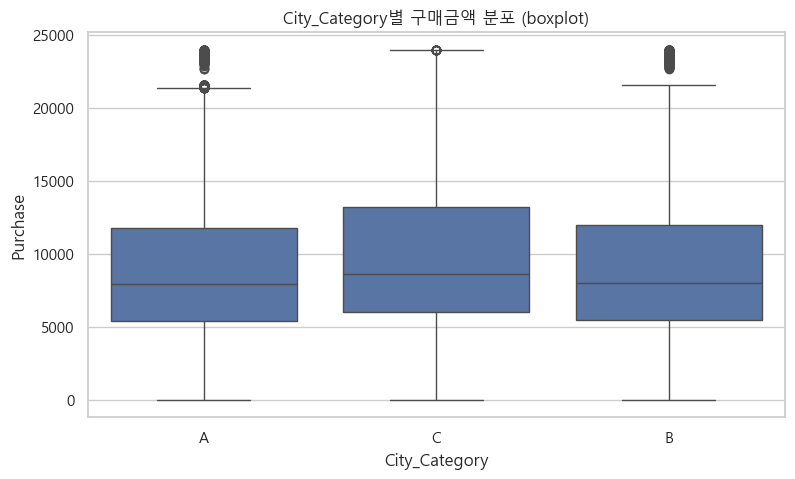

In [23]:
# 시각화: 분포 비교
sns.boxplot(data=df, x="City_Category", y="Purchase")
plt.title("City_Category별 구매금액 분포 (boxplot)")
plt.xlabel("City_Category")
plt.ylabel("Purchase")
plt.show()

In [24]:
# 요약 통계: mean/median/std 같이 보기
city_stats = df.groupby("City_Category")["Purchase"].agg(
    거래수="count",
    평균="mean",
    중앙값="median",
    표준편차="std"
).sort_index()
city_stats

,거래수,평균,중앙값,표준편차
City_Category,,,,
A,147720,8911.939216,7931.0,4892.115238
B,231173,9151.300563,8005.0,4955.496566
C,171175,9719.920993,8585.0,5189.465121


In [25]:
# Kruskal-Wallis (비모수): 분포 차이 검정
groups = [g["Purchase"].values for _, g in df.groupby("City_Category")]
kw = stats.kruskal(*groups)

n = len(df)
k = df["City_Category"].nunique()
eps2 = epsilon_squared_kw(kw.statistic, n, k)

pd.DataFrame({
    "검정": ["Kruskal-Wallis"],
    "통계량(H)": [kw.statistic],
    "p-value": [kw.pvalue],
    "효과크기(epsilon^2)": [eps2]
})

,검정,통계량(H),p-value,효과크기(epsilon^2)
0,Kruskal-Wallis,2303.712732,0.0,0.004184


가설 1 보조 분석: 어떤 쌍이 다른지(사후 비교)

Kruskal-Wallis가 유의하면, 최소 한 쌍은 다르다는 뜻이다.  
그래서 A-B, A-C, B-C를 Mann-Whitney U로 비교하고, Bonferroni로 보수적으로 보정한다.

In [26]:
# Pairwise Mann-Whitney U + Bonferroni
cats = list(df["City_Category"].dropna().unique())
cats.sort()

pairs = []
m = len(cats) * (len(cats) - 1) // 2

for i in range(len(cats)):
    for j in range(i+1, len(cats)):
        c1, c2 = cats[i], cats[j]
        x = df.loc[df["City_Category"] == c1, "Purchase"]
        y = df.loc[df["City_Category"] == c2, "Purchase"]
        u = stats.mannwhitneyu(x, y, alternative="two-sided")
        pairs.append({
            "비교": f"{c1} vs {c2}",
            "U": u.statistic,
            "p_raw": u.pvalue,
            "p_bonf": bonferroni(u.pvalue, m)
        })

pairwise_city = pd.DataFrame(pairs).sort_values("p_bonf")
pairwise_city

,비교,U,p_raw,p_bonf
1,A vs C,1.145864e+10,0.000000e+00,0.000000e+00
2,B vs C,1.847086e+10,3.007485e-285,9.022456e-285
0,A vs B,1.660508e+10,2.396485e-46,7.189456e-46


가설 1 해석 메모 (보고서 톤)

- 중앙값이 더 큰 그룹이 있다고 해서, 그 그룹이 '더 큰 도시'라고 말할 수는 없다.
- 대신, City_Category별로 구매금액의 전형적인 수준(중앙값)과 분산(표준편차)이 다를 수 있다고 정리한다.
- 유의성(p-value)과 효과크기(epsilon^2)를 같이 보고, 차이가 "있다/없다"를 과하게 단정하지 않는다.

## 가설 2. 도시 거주 기간에 따라 구매금액 특성은 달라지는가?

가설 설정
- H0: 거주 기간(Stay_In_Current_City_Years)별 구매금액(Purchase) 분포는 동일하다.
- H1: 거주 기간별 구매금액(Purchase) 분포는 동일하지 않다.

본 가설은 거주 기간이 구매금액을 증가시킨다는 인과를 전제하지 않는다.
거주 기간 그룹 간 구매금액 분포 특성(중앙값, 분산 등)의 차이가 관찰되는지 확인하는 데 목적이 있다.

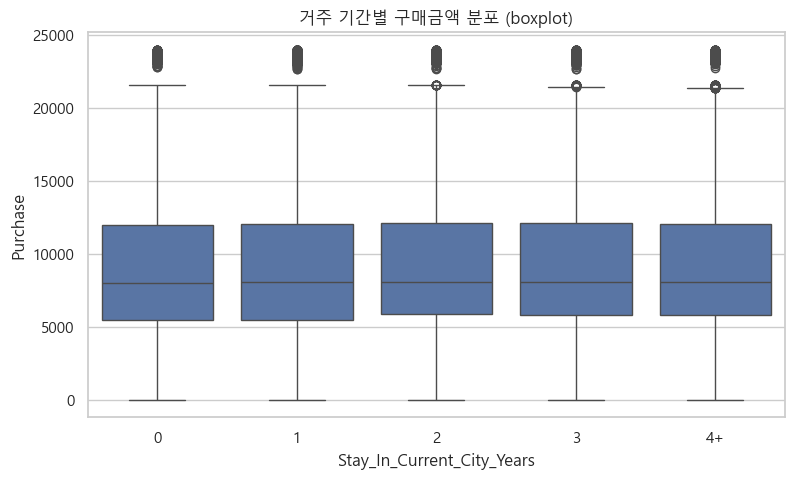

In [27]:
# 시각화
sns.boxplot(data=df, x="Stay_In_Current_City_Years", y="Purchase")
plt.title("거주 기간별 구매금액 분포 (boxplot)")
plt.xlabel("Stay_In_Current_City_Years")
plt.ylabel("Purchase")
plt.show()

In [28]:
stay_stats = df.groupby("Stay_In_Current_City_Years")["Purchase"].agg(
    거래수="count",
    평균="mean",
    중앙값="median",
    표준편차="std"
)
stay_stats

C:\Users\Admin\AppData\Local\Temp\ipykernel_2224\3200300001.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stay_stats = df.groupby("Stay_In_Current_City_Years")["Purchase"].agg(


,거래수,평균,중앙값,표준편차
Stay_In_Current_City_Years,,,,
0,74398,9180.075123,8025.0,4990.479940
1,193821,9250.145923,8041.0,5027.476933
2,101838,9320.429810,8072.0,5044.588224
3,95285,9286.904119,8047.0,5020.343541
4+,84726,9275.598872,8052.0,5017.627594


In [29]:
# Kruskal-Wallis
stay_groups = [g["Purchase"].values for _, g in df.groupby("Stay_In_Current_City_Years")]
kw2 = stats.kruskal(*stay_groups)

n2 = len(df)
k2 = df["Stay_In_Current_City_Years"].nunique()
eps2_2 = epsilon_squared_kw(kw2.statistic, n2, k2)

pd.DataFrame({
    "검정": ["Kruskal-Wallis"],
    "통계량(H)": [kw2.statistic],
    "p-value": [kw2.pvalue],
    "효과크기(epsilon^2)": [eps2_2]
})

C:\Users\Admin\AppData\Local\Temp\ipykernel_2224\676541247.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stay_groups = [g["Purchase"].values for _, g in df.groupby("Stay_In_Current_City_Years")]


,검정,통계량(H),p-value,효과크기(epsilon^2)
0,Kruskal-Wallis,34.097451,7.116707e-07,0.000055


가설 2 보조 검정: 단조 경향이 있는지 (Spearman)

거주 기간은 순서형이니까, 단조 증가/감소 경향이 있는지 Spearman 상관으로 본다.  
(값 매핑은 0,1,2,3,4로 두고 4+는 4로 본다)

In [30]:
# 순서형을 숫자로 매핑
stay_map = {"0":0, "1":1, "2":2, "3":3, "4+":4}
stay_numeric = df["Stay_In_Current_City_Years"].astype(str).map(stay_map)

rho, p = stats.spearmanr(stay_numeric, df["Purchase"])
pd.DataFrame({
    "검정": ["Spearman rank correlation"],
    "rho": [rho],
    "p-value": [p]
})

,검정,rho,p-value
0,Spearman rank correlation,0.005944,0.00001


가설 2 보조 검정: 분산 차이 (Levene)

"거주 기간이 길수록 분산이 커진다" 같은 말을 하고 싶다면,
최소한 분산이 그룹별로 다르다는 근거부터 확인해야 한다.

In [31]:
# Levene test for equal variances (중앙값 기반으로 robust)
levene = stats.levene(*stay_groups, center="median")
pd.DataFrame({
    "검정": ["Levene (median center)"],
    "통계량": [levene.statistic],
    "p-value": [levene.pvalue]
})

,검정,통계량,p-value
0,Levene (median center),6.371329,0.00004


가설 2 해석 가이드

- 분포 차이: Kruskal-Wallis로 거주 기간 그룹 간 분포 차이를 검정한다.
- 경향성: 거주 기간이 순서형인 점을 반영해 Spearman 상관으로 단조 경향 여부를 확인한다.
- 분산: Levene 검정으로 그룹 간 분산 차이 가능성을 확인한다.

세 결과를 함께 해석하여, 특정 방향(증가/감소)을 단정하기보다 관찰된 차이의 형태를 정리한다.

## 가설 3. 제품 카테고리별로 소비가 집중되는 고객 특성이 존재하는가?

가설 설정 (2개로 나눠서 본다)
- 3-A: Product_Category와 Gender는 독립인가?
  - H0: 독립이다
  - H1: 독립이 아니다

- 3-B: Product_Category와 Age는 독립인가?
  - H0: 독립이다
  - H1: 독립이 아니다

여기서는 Purchase 금액 자체보다,
어떤 고객 특성이 어떤 카테고리에서 더 자주 나타나는지(분포 편중)를 본다.

In [32]:
# 3-A: Product_Category x Gender
ct_gender = pd.crosstab(df["Product_Category"], df["Gender"])
ct_gender.head()

Gender,F,M
Product_Category,,
1,24831,115547
2,5658,18206
3,6006,14207
4,3639,8114
5,41961,108972


In [33]:
chi2, p, dof, expected = stats.chi2_contingency(ct_gender)
v = cramers_v(ct_gender)

pd.DataFrame({
    "검정": ["Chi-square (Product_Category x Gender)"],
    "chi2": [chi2],
    "dof": [dof],
    "p-value": [p],
    "효과크기(Cramer's V)": [v]
})

,검정,chi2,dof,p-value,효과크기(Cramer's V)
0,Chi-square (Product_Category x Gender),8070.411022,19,0.0,0.121127


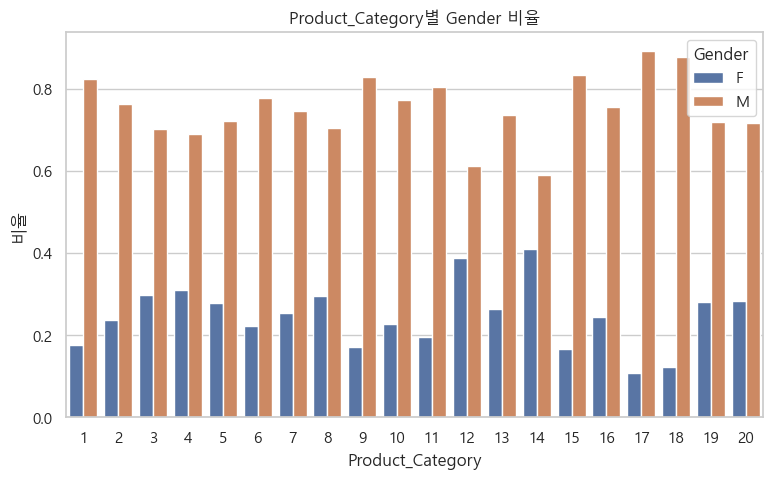

In [34]:
# 시각화: 카테고리별 성별 비율
gender_ratio = ct_gender.div(ct_gender.sum(axis=1), axis=0).reset_index()
gender_ratio_melt = gender_ratio.melt(id_vars="Product_Category", var_name="Gender", value_name="비율")

sns.barplot(data=gender_ratio_melt, x="Product_Category", y="비율", hue="Gender")
plt.title("Product_Category별 Gender 비율")
plt.xlabel("Product_Category")
plt.ylabel("비율")
plt.legend(title="Gender")
plt.show()

In [35]:
# 3-B: Product_Category x Age
ct_age = pd.crosstab(df["Product_Category"], df["Age"])
ct_age.iloc[:5, :5]

Age,0-17,18-25,26-35,36-45,46-50
Product_Category,,,,,
1,3585,26962,58249,27648,10474
2,805,4428,8928,4912,2105
3,1200,4710,7662,3854,1376
4,758,2463,4192,2354,990
5,4330,28522,61473,29377,11971


In [36]:
chi2_a, p_a, dof_a, expected_a = stats.chi2_contingency(ct_age)
v_a = cramers_v(ct_age)

pd.DataFrame({
    "검정": ["Chi-square (Product_Category x Age)"],
    "chi2": [chi2_a],
    "dof": [dof_a],
    "p-value": [p_a],
    "효과크기(Cramer's V)": [v_a]
})

,검정,chi2,dof,p-value,효과크기(Cramer's V)
0,Chi-square (Product_Category x Age),7637.28655,114,0.0,0.048105


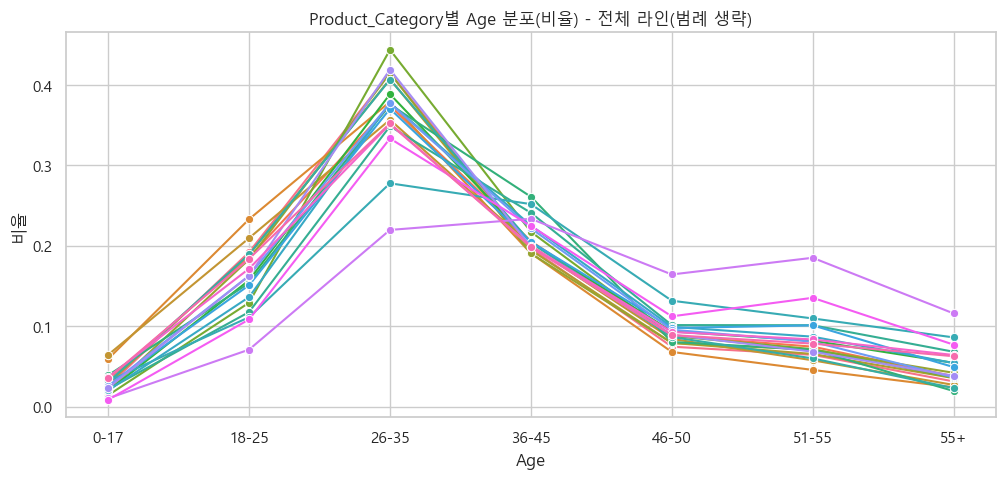

In [37]:
# 시각화: 카테고리별 연령 분포(비율)
age_ratio = ct_age.div(ct_age.sum(axis=1), axis=0).reset_index()
age_ratio_melt = age_ratio.melt(id_vars="Product_Category", var_name="Age", value_name="비율")

# 너무 빽빽하면 상위 카테고리 몇 개만 보고 싶을 수 있으니, 기본은 전체로 두되 figsize를 키움
plt.figure(figsize=(12, 5))
sns.lineplot(data=age_ratio_melt, x="Age", y="비율", hue="Product_Category", marker="o", legend=False)
plt.title("Product_Category별 Age 분포(비율) - 전체 라인(범례 생략)")
plt.xlabel("Age")
plt.ylabel("비율")
plt.show()

가설 3 해석 가이드

- Chi-square 검정이 유의하면, 두 변수가 독립이 아니라는 결론까지는 가능하다.
- 다만 표본이 큰 경우 작은 차이도 유의하게 나타날 수 있으므로, 효과크기(Cramer's V)를 함께 확인한다.
- 효과크기가 작은 경우에는 '강한 편중'이 아니라 '약한 편중' 또는 '경미한 차이' 수준으로 정리하는 것이 적절하다.

# 결론 및 시사점 (조금 더 제대로)

여기서는 한 문장으로 끝내지 말고,
가설 1~3을 연결해서 '무엇을 배웠는지'를 남긴다.

## 결론 요약

1) City_Category별로 구매금액 분포가 달라질 수 있다  
- 중앙값이 높은 유형이 있는 반면, 분산이 큰 유형도 있다.
- 이 차이는 "도시 규모" 같은 의미 해석으로 점프하지 않고, '유형 간 소비 구조 차이'로만 정리하는 게 안전하다.

2) 거주 기간은 단독 변수로는 설명력이 제한될 수 있다  
- 분포 차이, 경향, 분산을 같이 봤을 때 일관된 방향성이 약하면,
  거주 기간만으로 소비를 설명하기는 어렵다.
- 대신 City_Category나 Product_Category 같은 변수와 결합해서 보는 쪽이 더 낫다.

3) 제품 카테고리에는 고객 특성의 편중이 존재할 수 있다  
- Product_Category와 Gender/Age의 독립성 검정이 유의하면,
  카테고리마다 주 소비자 집단이 갈릴 가능성이 있다.
- 다만 효과크기(Cramer's V)가 작으면, "엄청난 차이"로 말하지 말고 "약한 편중" 정도로 정리하는 편이 맞다.

## 실무적으로 바꿔볼 수 있는 액션 아이디어

- City_Category별로 프로모션 설계를 다르게 해볼 수 있다
  - 중앙값이 높은 유형: 기본 단가 높은 번들/세트 전략
  - 분산이 큰 유형: 상단(고액) 고객 대상 업셀/프리미엄 프로모션

- 거주 기간은 단독 타겟팅 기준으로 쓰기 전에 재검토
  - 거주 기간만 보지 말고, City_Category x Product_Category 같이 묶어서 세그먼트를 잡는 게 더 설득력 있다

- Product_Category별 핵심 고객군이 보이면, 메시지/채널을 미세조정
  - 예: 특정 카테고리는 특정 연령대 비중이 높다 → 그 연령대가 많이 쓰는 채널과 카피 톤을 맞추기

## 결론 및 한계

본 분석은 마스킹된 범주형 변수들을 포함하고 있어, '도시 규모'나 '직업명' 등 구체적 의미를 단정하는 해석은 지양하였다. 대신 유형 간 구매금액 분포 차이 여부를 통계적으로 확인하고, 효과크기를 함께 제시하여 결과 해석의 균형을 맞추었다.

한계
- City_Category, Occupation, Product_Category의 실제 의미가 공개되지 않아, 관찰된 차이를 외부 요인(소득, 지역경제 등)으로 직접 연결하기 어렵다.
- 본 분석은 관측 데이터 기반으로, 인과관계를 주장하지 않는다.

후속 분석 제안
- City_Category와 Product_Category의 결합 세그먼트(교차 그룹)를 구성해 구매금액 분포 및 상위 매출 기여도를 비교한다.
- Purchase를 목표변수로 하는 예측 모델(예: 트리 기반)로 변수 중요도를 확인하되, 해석은 유형 기반으로 제한한다.